# Notebook to make Fig. 9

In [1]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd
import lal
import importlib

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator

from textwrap import wrap
from scipy.signal import hilbert

import seaborn as sns

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("",['#CC79A7', '#D55E00', '#E69F00', '#0072B2'])


import sys
sys.path.append('../scripts')
from helper_functions import *
sys.path.append('../utils')
import reconstructwf as rwf

style.use('plotting.mplstyle')

data_dir = '../data/' 

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


Load in reconstructions and angles from before/after each cutoff time

In [2]:
reconstruction_dict_all = np.load(data_dir+"waveform_reconstructions_all_detectors.npy", allow_pickle=True).item()
reconstruction_dict = {k:reconstruction_dict_all[k]['L1'] for k in reconstruction_dict_all.keys()}

Define timeseries

In [3]:
# 0M <-> seconds
t0_0M_dict = {}
t0_0M_geo = 1242442967.405764
dt_10M = 0.0127 # 10 M = 12.7 ms 
dt_1M = dt_10M/10.

ra = 6.07546535866838
dec = -0.8000357325337637

# define t_0M in each detector in seconds
for ifo in ['H1', 'L1', 'V1']: 
    
    t_delay = lal.TimeDelayFromEarthCenter(lal.cached_detector_by_prefix[ifo].location, ra, dec, t0_0M_geo)
    t0_0M_dict[ifo] = t0_0M_geo + t_delay
    
# Transform timeseries into into units of M
reconstruction_times_M = (reconstruction_dict['time samples']- t0_0M_dict['L1'])/dt_1M

Figure out what regions have inconsistent 50% confidence intervals

In [4]:
bounds = [-50, 60]
mask = (reconstruction_times_M > bounds[0]) & (reconstruction_times_M < bounds[1])

q = 0.50
q_arr = [0.5-q/2, 0.5+q/2]

quants_full = np.quantile(reconstruction_dict['full']['wh'], q_arr, axis=0)[:,mask]
quants_m40M = np.quantile(reconstruction_dict['rd m10M']['wh'], q_arr, axis=0)[:,mask]

abs_wh_full = np.max(np.abs(quants_full), axis=0)
abs_wh_m40M = np.min(np.abs(quants_m40M), axis=0)

idxs = abs_wh_full < abs_wh_m40M

times = reconstruction_times_M[mask]
print(times[idxs])

avg_full = np.mean(reconstruction_dict['full']['wh'], axis=0)[mask]

[-30.36269991 -29.97822649 -29.59375306 -29.20927964
 -28.82480621 -28.44033279 -28.05585936 -27.67138594
 -17.29060346 -16.90613003 -16.52165661 -16.13718318
 -15.75270976 -15.36823633 -14.98376291 -14.59928948
 -14.21481606  -5.37192728  -4.98745385]


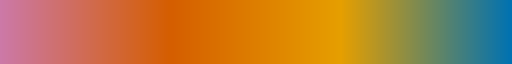

In [5]:
cmap

### Make figure 09

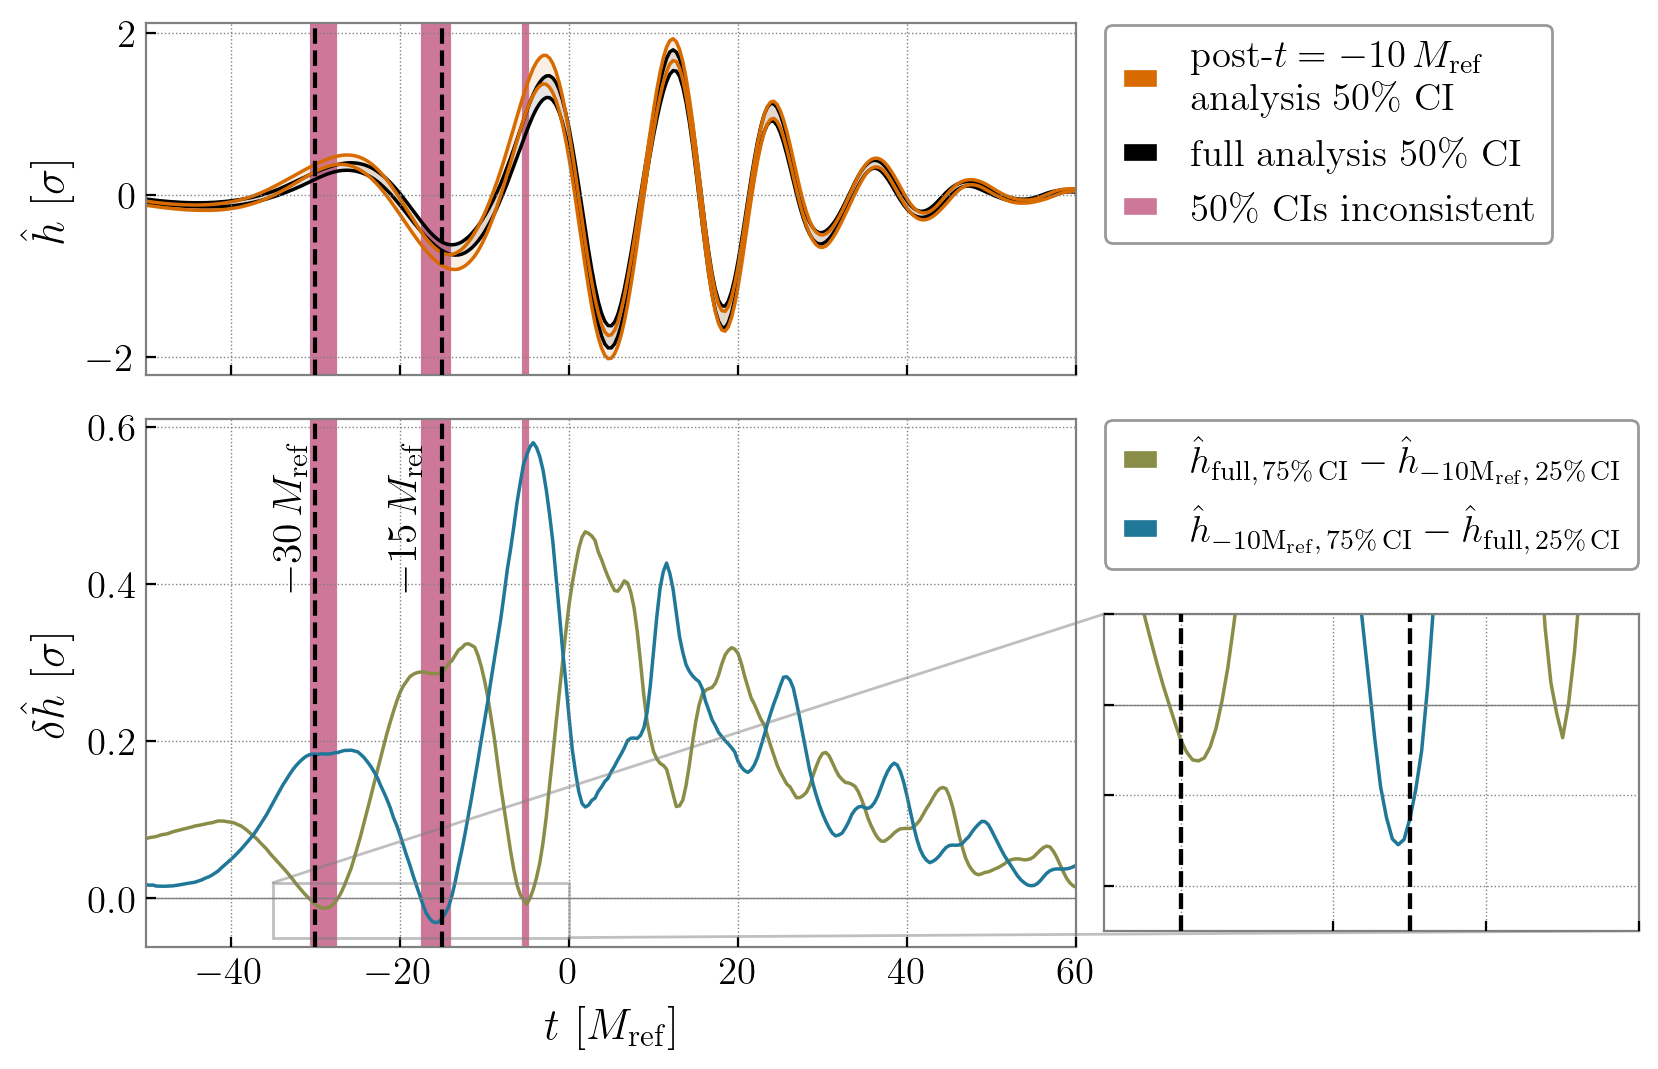

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(6,6), sharex=True, gridspec_kw={'height_ratios': [2, 3]})

# inset axes
l = 0.575
w = 0.6
dx = 0.03
axin = axes[1].inset_axes([1+dx, dx, l, w])

# Fill in regions where the waveforms are inconsistent at 50% credible interval
for ax in axes:
    for t in times[idxs]:
        ax.axvline(t, color=cmap(0.03), zorder=0)
        
    for t in [-15, -30]:
        ax.axvline(t, color='k', ls='--', zorder=5)
        axin.axvline(t, color='k', ls='--', zorder=5)

'''
upper subplot: whitened strain 
'''
# Full 
axes[0].plot(times, quants_full.T, lw=1.25, color='k')
axes[0].fill_between(times, quants_full[0], y2=quants_full[1], color='k', alpha=0.1)

# m40M
axes[0].plot(times, quants_m40M.T, lw=1.25, color=cmap(0.4))
axes[0].fill_between(times, quants_m40M[0], y2=quants_m40M[1], color=cmap(0.4), alpha=0.1)

axes[0].set_ylabel(r'$\hat h~[\sigma]$', fontsize=16)
axes[0].set_xlim(*bounds)


'''
lower subplot: difference whitened strain envelopes
'''
for ax in [axes[1], axin]:
    
    ax.plot(times, (quants_full[1] - quants_m40M[0]), lw=1.25, color=cmap(0.8))
    ax.plot(times, (quants_m40M[1] - quants_full[0]), lw=1.25, color=cmap(0.95))
    ax.axhline(0, lw=0.5, color='gray')

axes[1].set_xlabel(r'$t~[M_\mathrm{ref}]$', fontsize=16)

for t,dt in zip([-15, -30], [-6.5, -5.1]):
    axes[1].text(t+dt, 0.4, f'${{{t}}}\,M_\mathrm{{ref}}$', color='k', 
                 fontsize=15, zorder=5, rotation=90)
    
    
axes[1].set_ylabel(r'$\delta \hat h~[\sigma]$', fontsize=16)



'''
legends
'''
legend_handles1 = [
    Line2D([], [], color=cmap(0.4), label=r'post-$t=-10\,M_\mathrm{ref}$'+'\nanalysis 50\% CI'),
    Line2D([], [], color='k', label='full analysis 50\% CI'),
    Line2D([], [], color=cmap(0.03), label='50\% CIs inconsistent'),
]
legend_handles2 = [
    Line2D([], [], color=cmap(0.8), 
           label='$\hat h_\mathrm{full,\,75\%\,CI} - \hat h_\mathrm{-10M_\mathrm{ref},\,25\%\,CI}$'),
    Line2D([], [], color=cmap(0.95), 
           label='$\hat h_\mathrm{-10M_\mathrm{ref},\,75\%\,CI} - \hat h_\mathrm{full,\,25\%\,CI}$'),
   
]

legend_kws = dict(frameon=True, fancybox=True, fontsize=14, loc='upper left')
axes[0].legend(handles = legend_handles1, **legend_kws, bbox_to_anchor=(1.01, 1.05))
axes[1].legend(handles = legend_handles2, **legend_kws, bbox_to_anchor=(1.01, 1.035))


"""
format inset
"""

axin.set_xlim(-35, 0)
axin.set_ylim(-0.05, 0.02)

axes[1].indicate_inset_zoom(axin)

axin.set_xticklabels([])
axin.set_yticklabels([])

plt.subplots_adjust(hspace=0.1)

plt.savefig('figure_09.pdf', bbox_inches='tight')
plt.show()